<a href="https://colab.research.google.com/github/selahattinozturk/Urbansound-Classification/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
CUR_PATH = '/content/drive/My Drive/EEE485'

Mounted at /content/drive


In [ ]:
classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
class_idx = {c: i for i, c in enumerate(classes)}

In [ ]:
def onehot_encoder(y_train):
  onehot_y_train = []
  for yi in y_train:
    # as this is svm, we need -1 for irrelevant classes
    onehot_yi = [-1 for i in range(len(classes))]
    onehot_yi[class_idx[yi]] = 1
    onehot_y_train.append(onehot_yi)

  return np.array(onehot_y_train).copy()

In [ ]:
def standardize_data(X_train, X_test):
  mean = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  return X_train, X_test

In [ ]:
def import_data(cv_idx): # cv_index = {0, 1, .., 9}
  names = [f'fold{i}.csv' for i in range(1, 11)]
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for f_idx, name in enumerate(names):
    fold_data = pd.read_csv(f'{CUR_PATH}/data/{name}', index_col=0)
    fold_X = fold_data.drop(["filename", "class"], axis=1)
    # fold_X = fold_X.drop([f"mfcc_min{i}" for i in range(1, 26)], axis=1)
    # fold_X = fold_X.drop([f"mfcc_max{i}" for i in range(1, 26)], axis=1)
    fold_y = fold_data['class'].values.tolist()
    fold_X = fold_X.values.tolist()
    if f_idx == cv_idx:
      X_test.extend(fold_X)
      y_test.extend(fold_y)
    else:
      X_train.extend(fold_X)
      y_train.extend(fold_y)
  
  return np.array(X_train).copy(), np.array(X_test).copy(), y_train, y_test

In [ ]:
def prepare_dataset(cv_idx):
  X_train, X_test, y_train, y_test = import_data(cv_idx)
  X_train, X_test = standardize_data(X_train, X_test)
  y_train, y_test = onehot_encoder(y_train), onehot_encoder(y_test)
  X_train, X_test = pca(X_train, X_test)
  X_train = np.insert(X_train, 0, 1, axis=1)
  X_test = np.insert(X_test, 0, 1, axis=1)
  return X_train, X_test, y_train, y_test

In [ ]:
import matplotlib.pyplot as plt

def pca(X_train, X_test): # X must be standardized
  CUTOFF = 90
  n, p = X_train.shape
  total_variance = (np.linalg.norm(X_train, ord="fro") ** 2) / n
  sigma = (X_train.T @ X_train) / n
  w, v = np.linalg.eig(sigma)
  w_argsort = w.argsort()[::-1]
  w[::-1].sort()
  v = v[w_argsort]
  pve_first_k = 0

  project_X_train = X_train @ v
  pve_first_k_all = np.zeros((len(v),1))
  needed_k = []

  for eig_idx in range(len(w)):
    pve_first_k += (project_X_train[:,eig_idx].T @ project_X_train[:,eig_idx]) / (n * total_variance)
    pve_first_k_all[eig_idx] = pve_first_k
    if pve_first_k > CUTOFF / 100:
      needed_k.append(eig_idx)

  k = needed_k[0]
  u = v[:,:k]
  X_train = X_train @ u
  X_test = X_test @ u

  '''plt.plot(np.linspace(1, p, p),100 * pve_first_k_all)
  plt.title('# of PC vs. PVE (%)\n'
            '# of PC where PVE exceeds {0:d}% first time: {1:d}'.format(CUTOFF,k))
  plt.xlabel('# of PC')
  plt.ylabel('PVE (%)')
  plt.plot(k, 100 * pve_first_k_all[k],'rx')
  plt.plot(np.linspace(1, p, p), CUTOFF * np.ones(p),'r--')'''
  return X_train, X_test


In [ ]:
def gradient(W, X, Y, C):
  # print(f'X@W.shape: {(X@W).shape}, Y.shape: {Y.shape}')
  return W if max(0, 1 - Y * (X @ W)) == 0 else W - C * Y * X.T

In [ ]:
def loss(W, X, Y, C):
  n, p = X.shape
  hinge = 1 - Y * (np.dot(X, W))
  hinge[hinge < 0] = 0
  loss = (np.linalg.norm(W, ord="fro") ** 2) / 2 + C * np.sum(hinge) / n
  return loss

In [ ]:
def predict(W, X):  
  n, p = X.shape
  predictions = np.zeros((n, 1))
  for i in range(n):
      predictions[i] = np.argmax(X[i,:] @ W)

  return predictions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def eval_metrics(y_preds, y_true):
    k = len(classes)
    conf_matrix = np.zeros((k, k), dtype=int)
    for i in range(len(y_preds)):
        conf_matrix[y_true[i], y_preds[i]] += 1

    acc = (y_preds == y_true).sum() / len(y_preds)

    precision, recall, f1 = np.zeros(k), np.zeros(k), np.zeros(k)

    for j in range(k):
        precision[j] = conf_matrix[j, j] / np.sum(conf_matrix[:, j]) * 100
        recall[j] = conf_matrix[j, j] / np.sum(conf_matrix[j, :]) * 100
        f1[j] = 2 * precision[j] * recall[j] / (precision[j] + recall[j])
    
    conf_matrix = pd.DataFrame(data=conf_matrix, index=classes, columns=classes)
    plt.figure(figsize=(10, 8), dpi=100)
    plt.title("Confusion Matrix - Softmax Regression")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    
    precision = [f'{p:.2f}' for p in precision]
    recall = [f'{p:.2f}' for p in recall]
    f1 = [f'{p:.2f}' for p in f1]
    
    heatmap = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt="d")
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
    heatmap.set_xlabel('Predicted Labels', fontsize=12)
    heatmap.set_ylabel('True Labels', fontsize=12)

    plt.show()

    return acc, precision, recall, f1

In [ ]:
def stochastic_gd(X, Y, epochs=100, lr=0.001, C=1):
  n, p = X.shape
  W = np.zeros((p, Y.shape[1]))
  prev_loss = 1e15
  last_epoch = 0

  losses = []
  for epoch in range(epochs): 
    perm = np.random.permutation(n)
    
    for i in range(Y.shape[1]):
      yj = Y[:,i]
      for j in perm:
        x = X[j,:].reshape((1,p))
        W[:,i] -= lr * gradient(W[:,i].reshape((p,1)), x, yj[j], C).reshape((p,))
      
    cur_loss = loss(W, X, Y, C)

    if (prev_loss - cur_loss) < (prev_loss / 10000):
      break

    prev_loss = cur_loss
    losses.append(prev_loss)
    last_epoch += 1

  return W, losses, last_epoch

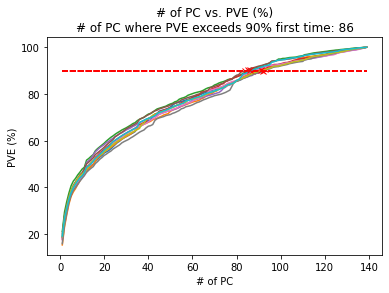

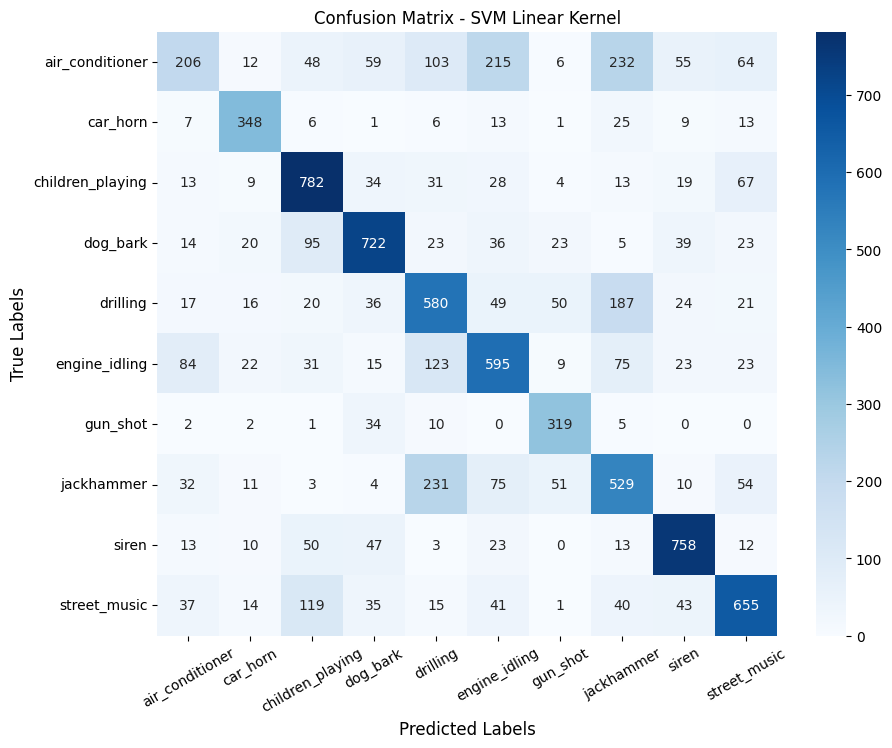

Epoch: 1000 with last epoch 43, Learning rate: 1e-06, C: 100, Test Accuracy: 0.629, Time: 400.856 seconds


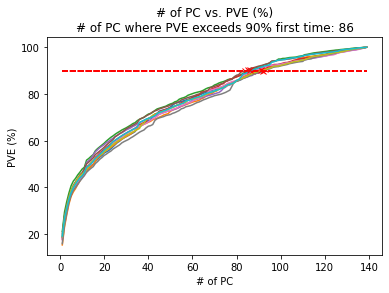

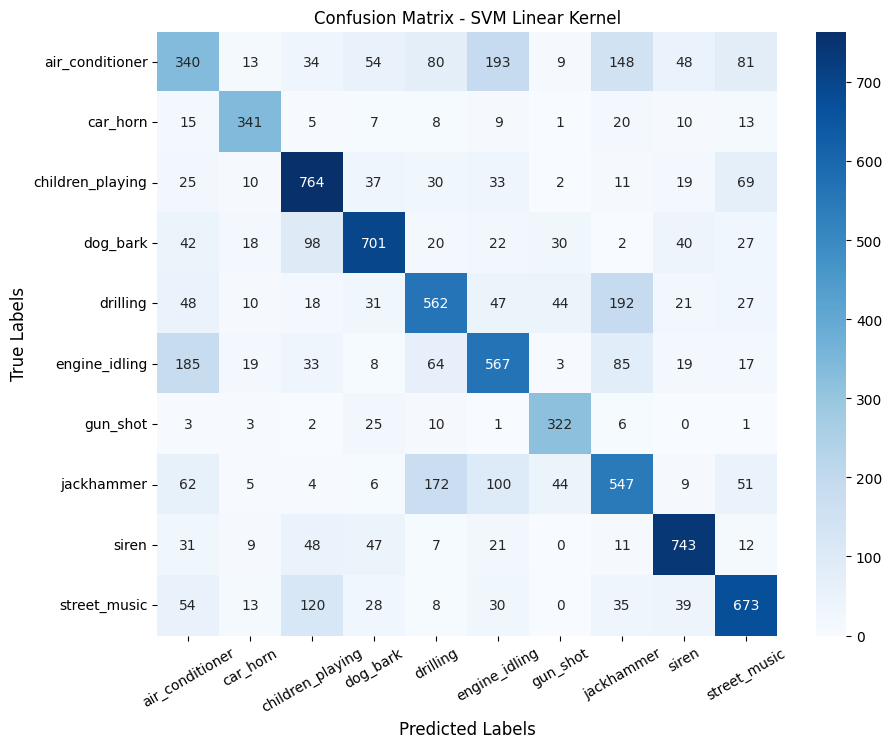

Epoch: 1000 with last epoch 8, Learning rate: 1e-06, C: 1000, Test Accuracy: 0.637, Time: 129.706 seconds


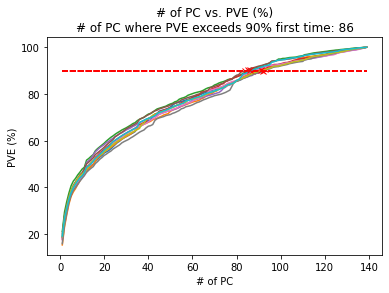

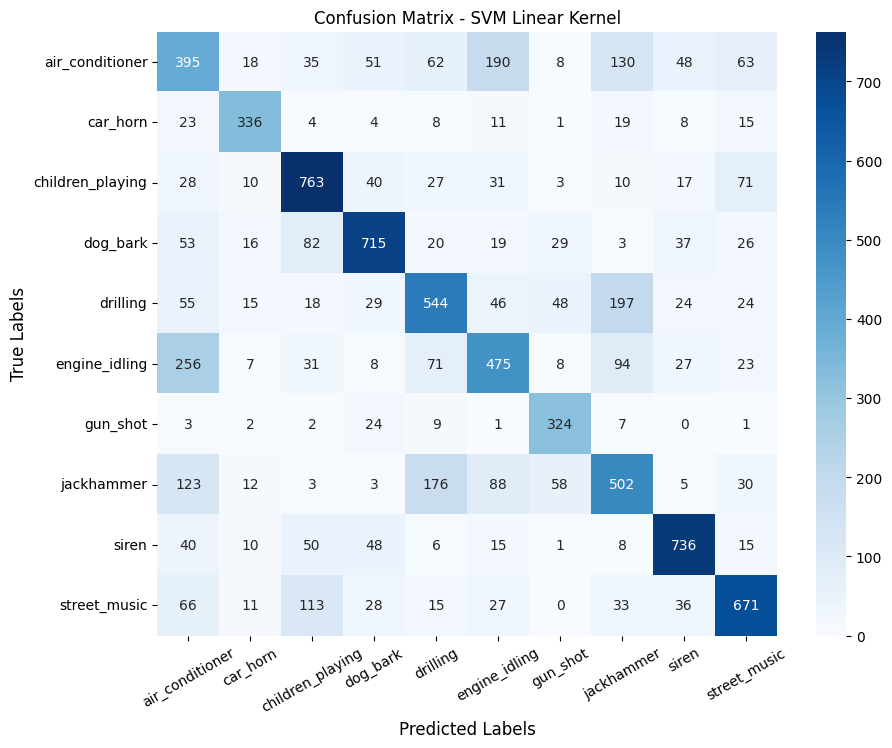

Epoch: 1000 with last epoch 9, Learning rate: 1e-06, C: 1000, Test Accuracy: 0.625, Time: 108.573 seconds


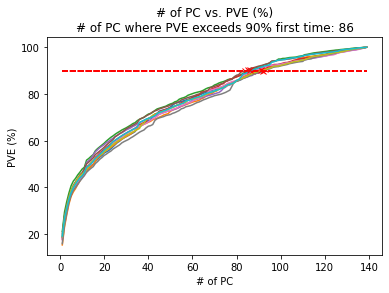

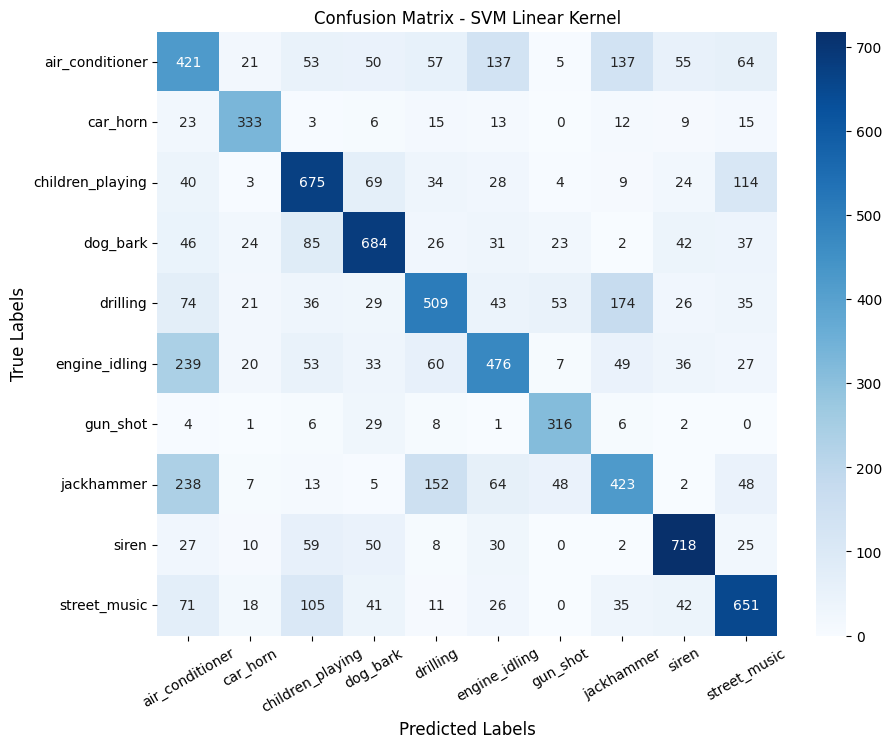

Epoch: 1000 with last epoch 1, Learning rate: 1e-06, C: 10000, Test Accuracy: 0.596, Time: 29.554 seconds


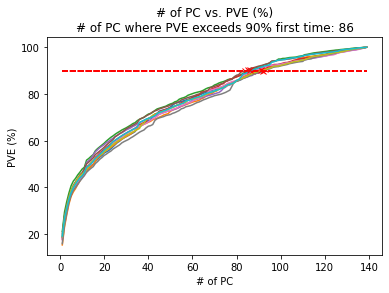

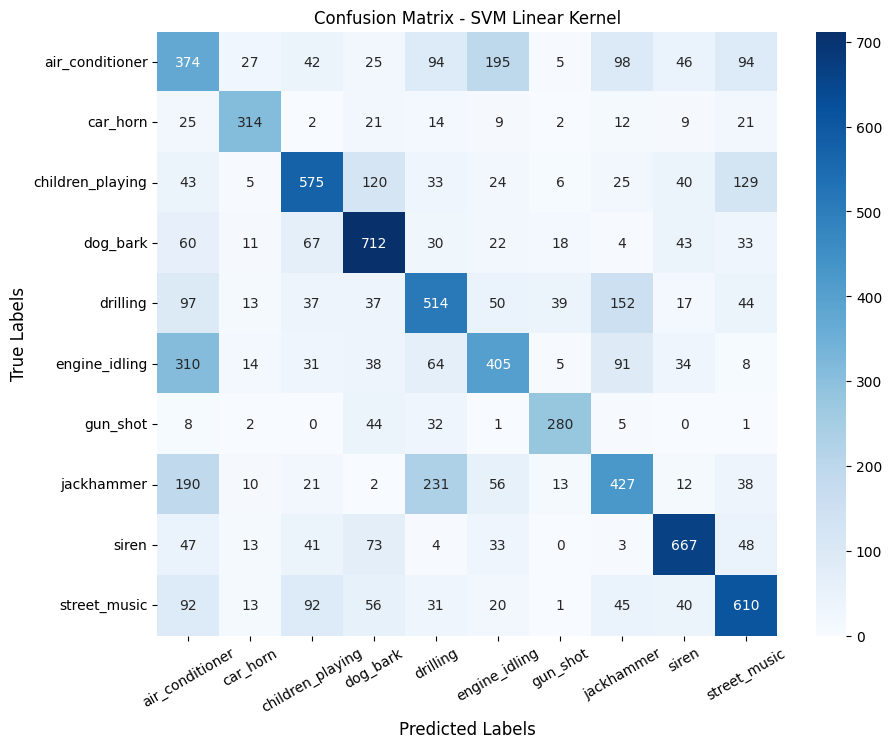

Epoch: 1000 with last epoch 1, Learning rate: 1e-06, C: 100000, Test Accuracy: 0.559, Time: 25.719 seconds


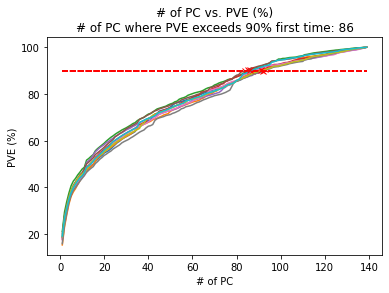

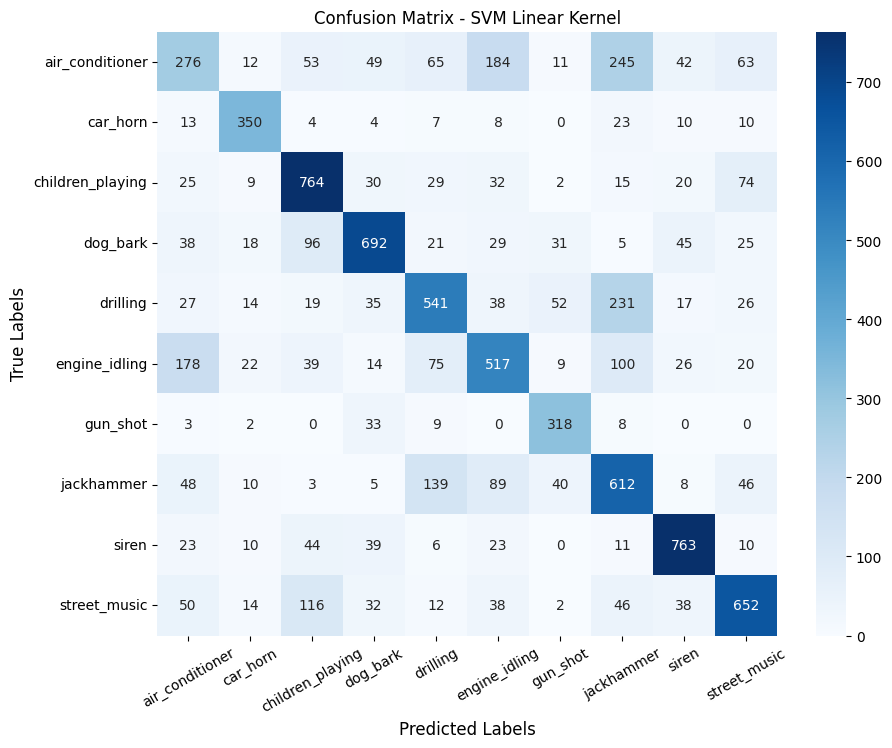

Epoch: 1000 with last epoch 6, Learning rate: 1e-05, C: 100, Test Accuracy: 0.628, Time: 67.089 seconds


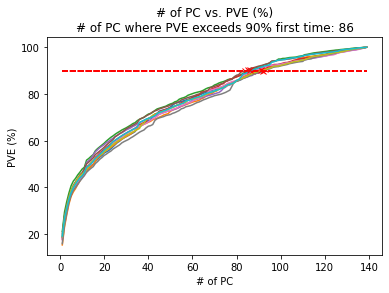

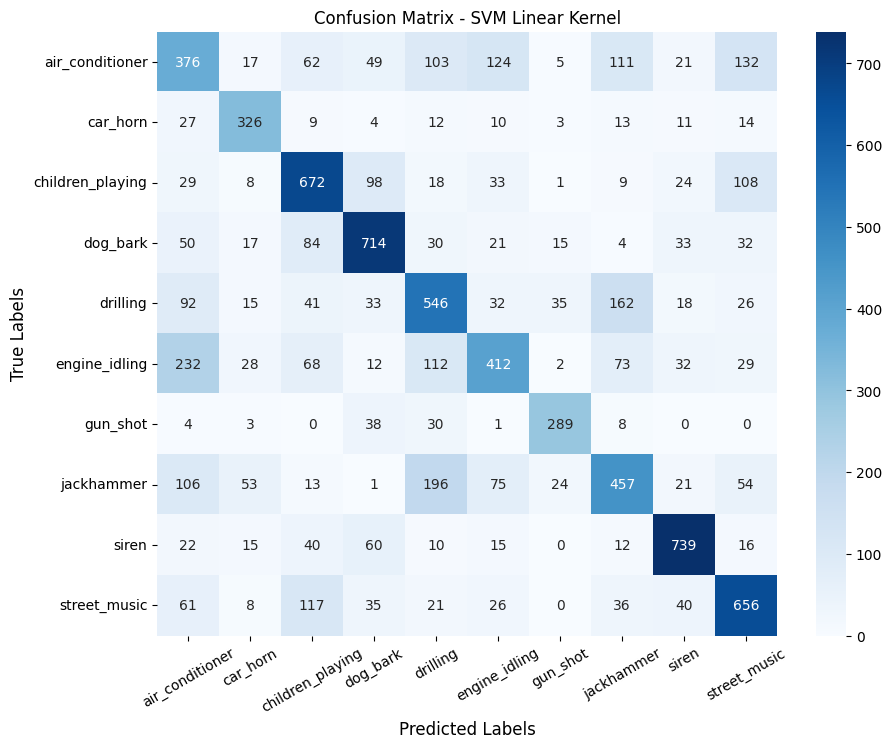

Epoch: 1000 with last epoch 2, Learning rate: 1e-05, C: 1000, Test Accuracy: 0.594, Time: 36.014 seconds


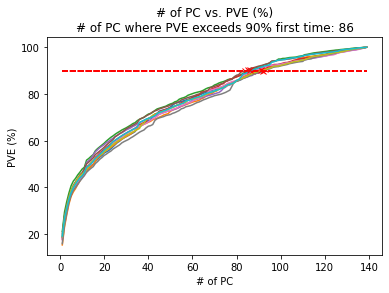

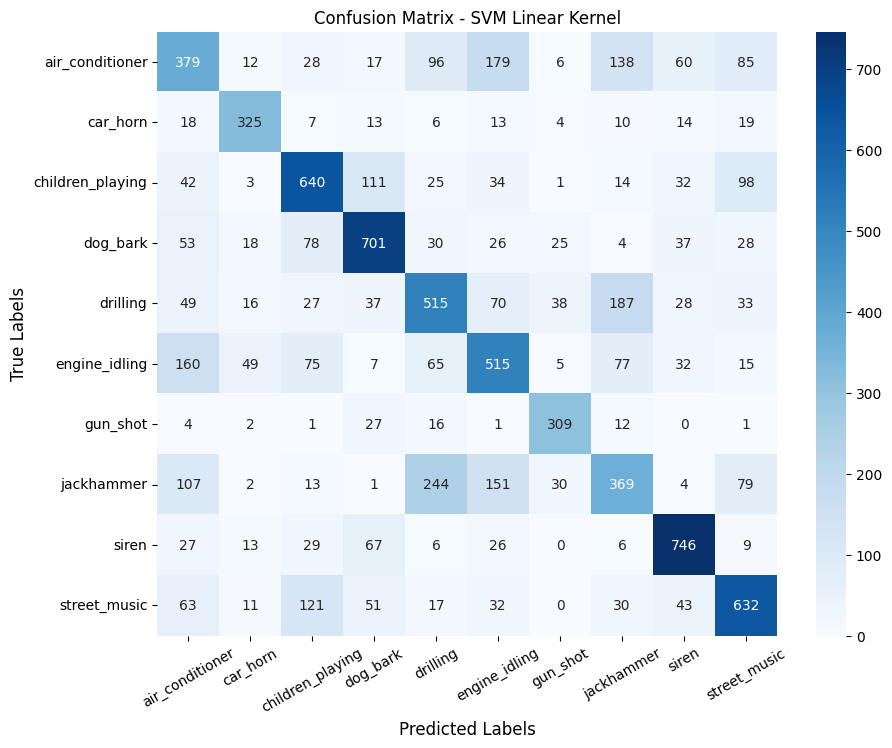

Epoch: 1000 with last epoch 1, Learning rate: 1e-05, C: 1000, Test Accuracy: 0.588, Time: 29.529 seconds


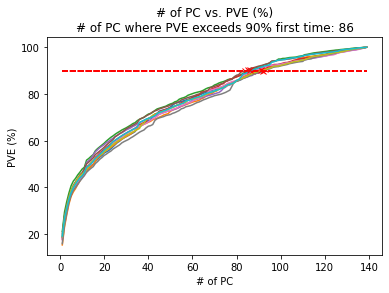

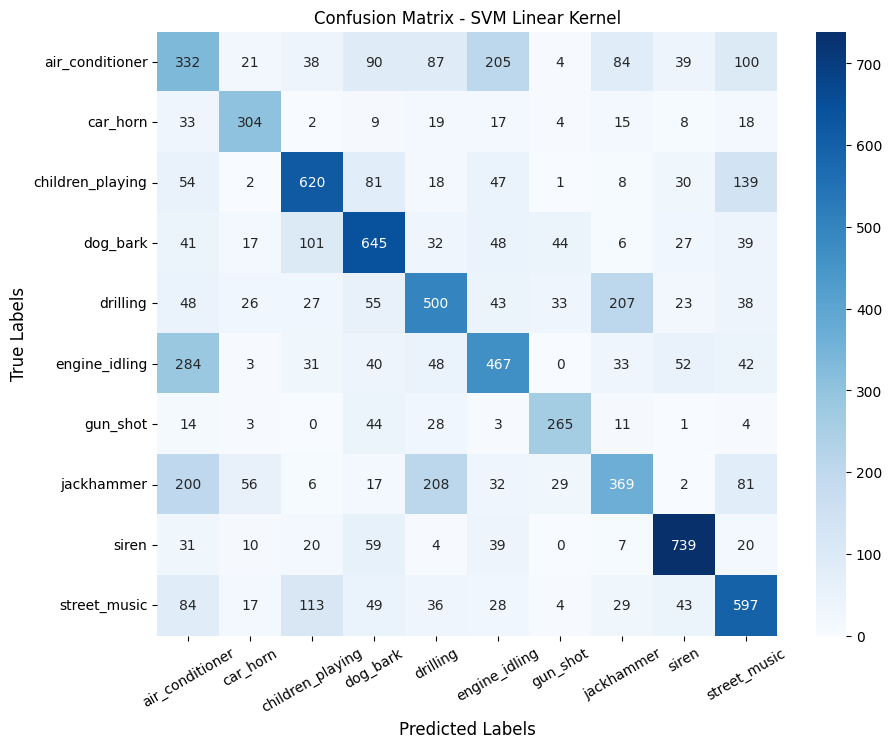

Epoch: 1000 with last epoch 3, Learning rate: 1e-05, C: 10000, Test Accuracy: 0.554, Time: 32.225 seconds


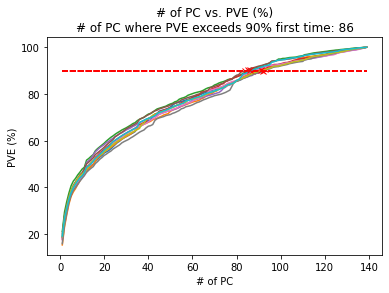

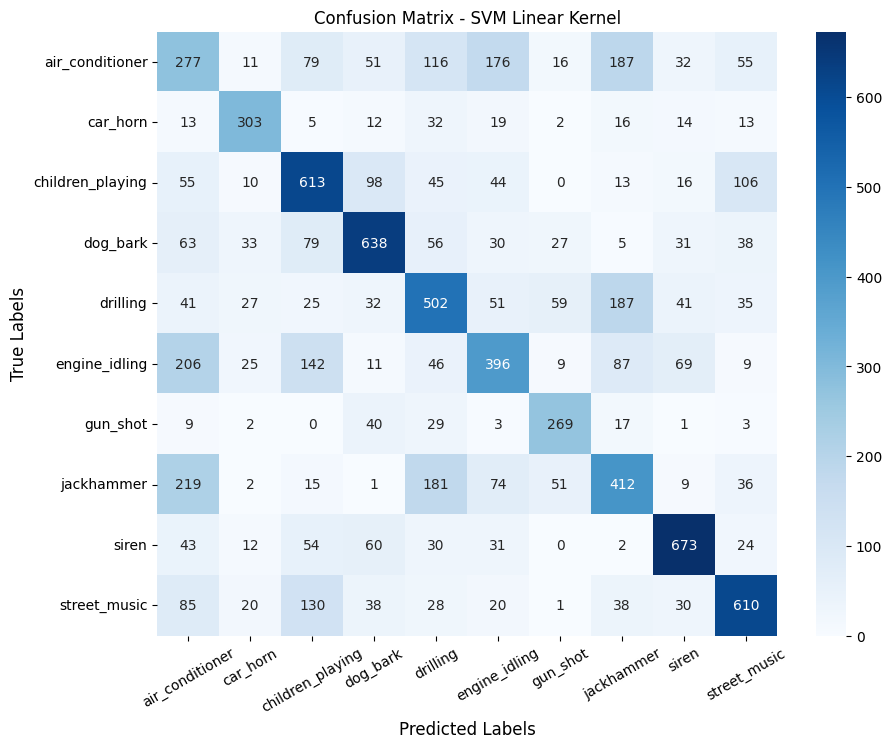

Epoch: 1000 with last epoch 1, Learning rate: 1e-05, C: 100000, Test Accuracy: 0.538, Time: 28.844 seconds


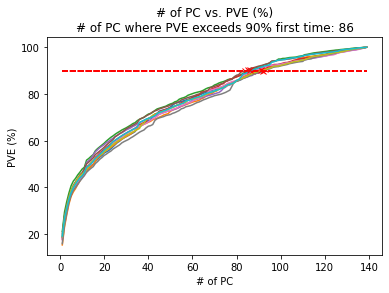

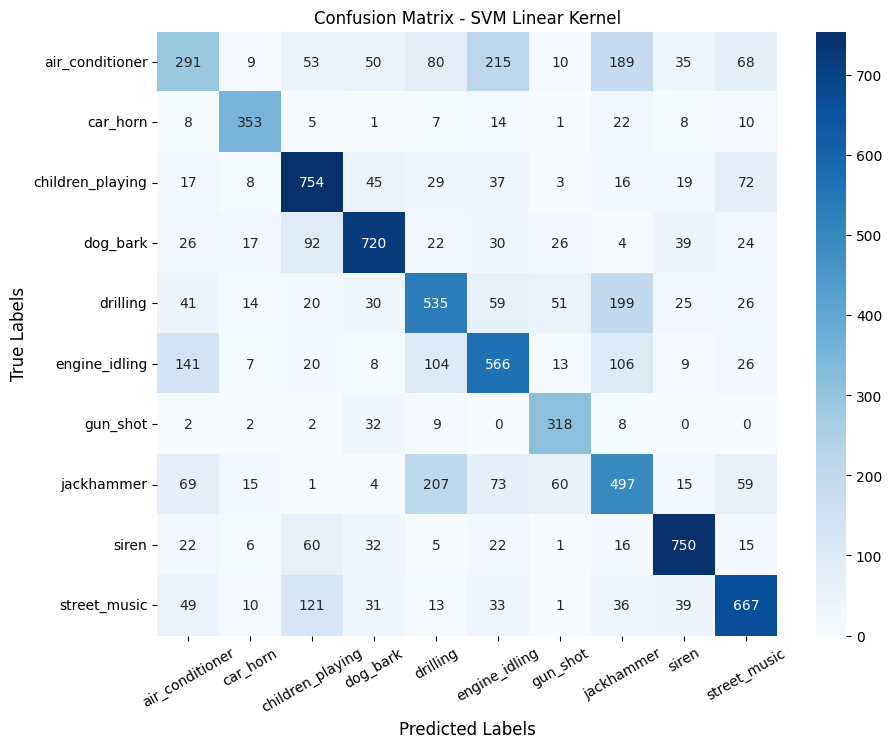

Epoch: 1000 with last epoch 5, Learning rate: 1e-05, C: 100, Test Accuracy: 0.624, Time: 73.982 seconds


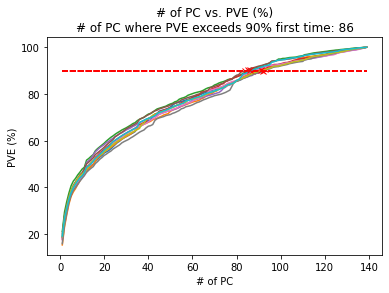

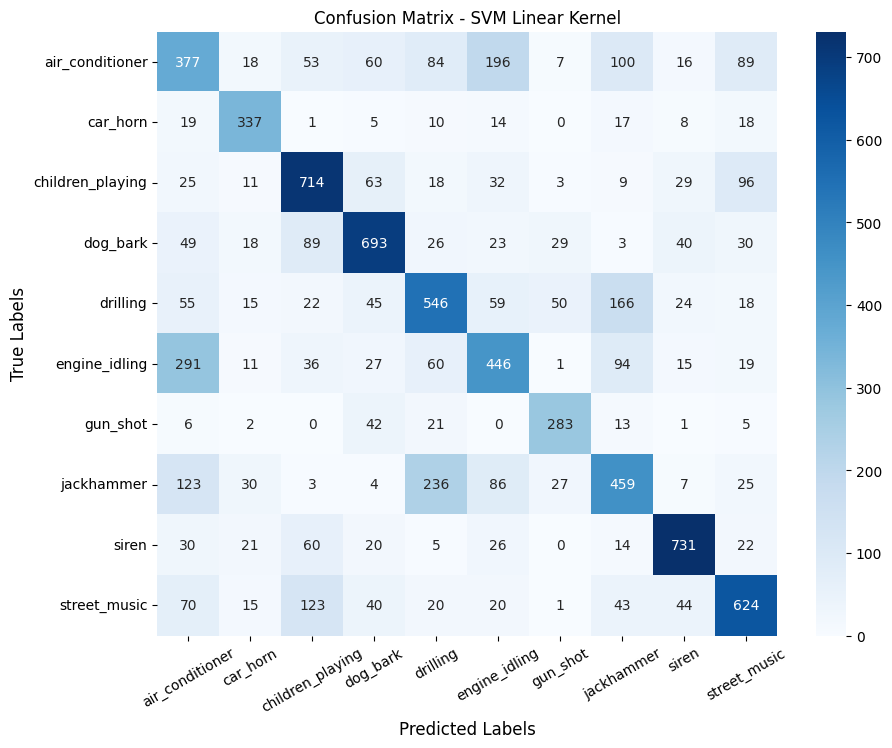

Epoch: 1000 with last epoch 3, Learning rate: 1e-05, C: 1000, Test Accuracy: 0.597, Time: 34.923 seconds


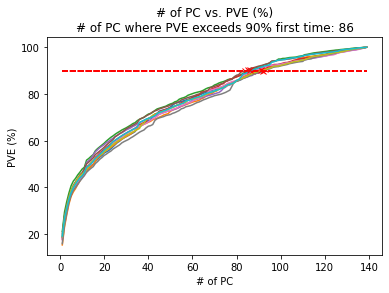

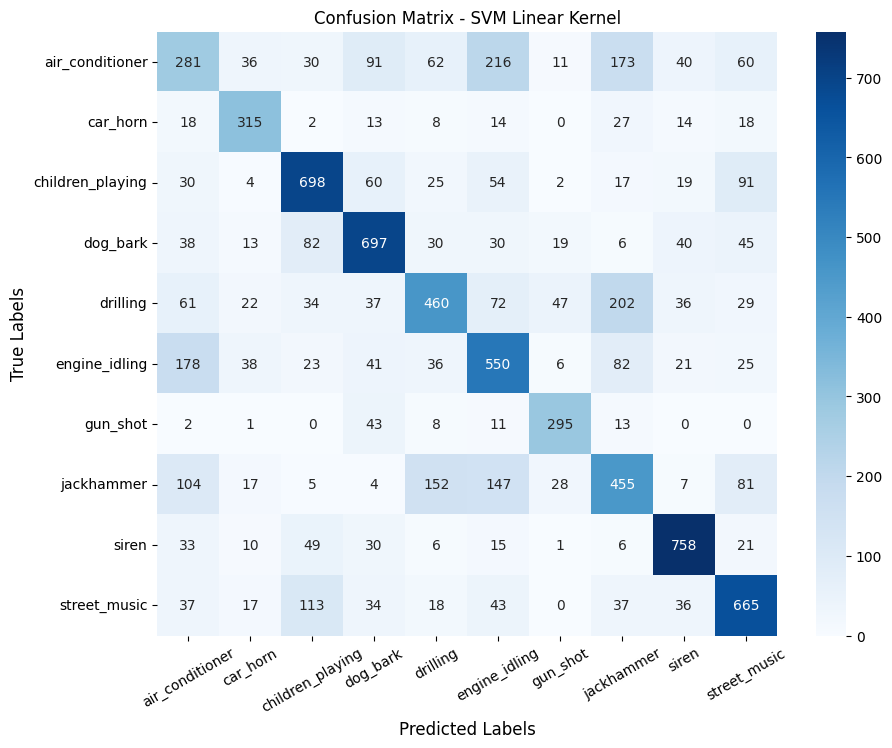

Epoch: 1000 with last epoch 3, Learning rate: 1e-05, C: 1000, Test Accuracy: 0.593, Time: 36.143 seconds


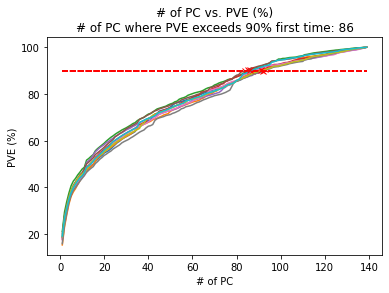

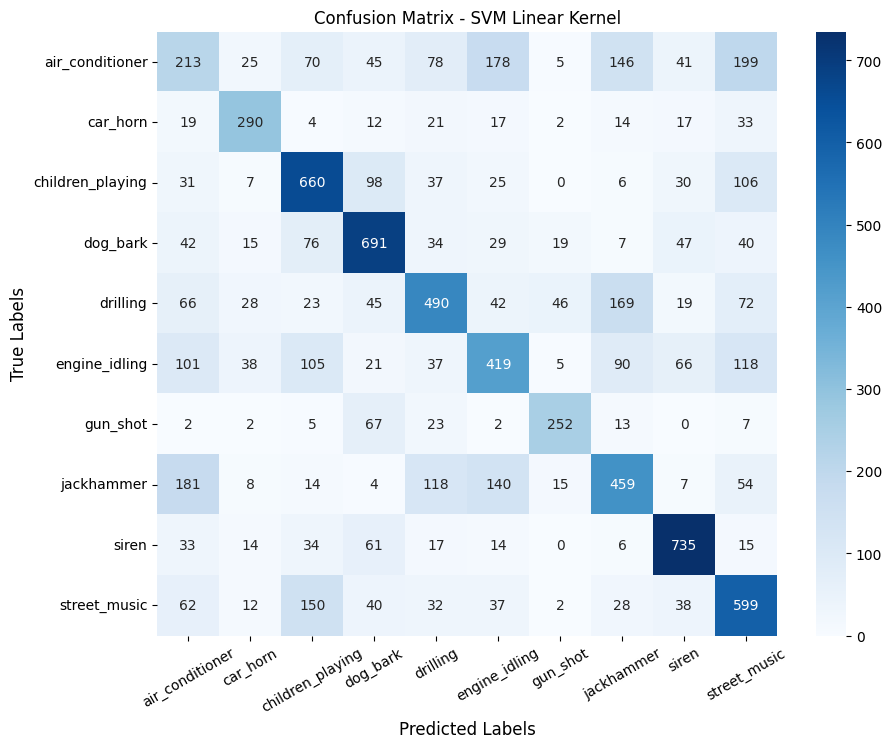

Epoch: 1000 with last epoch 1, Learning rate: 1e-05, C: 10000, Test Accuracy: 0.551, Time: 30.963 seconds


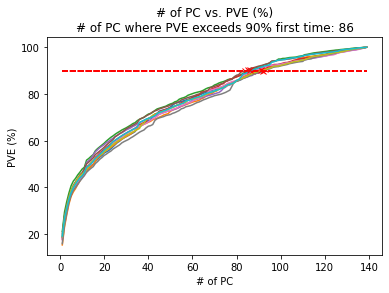

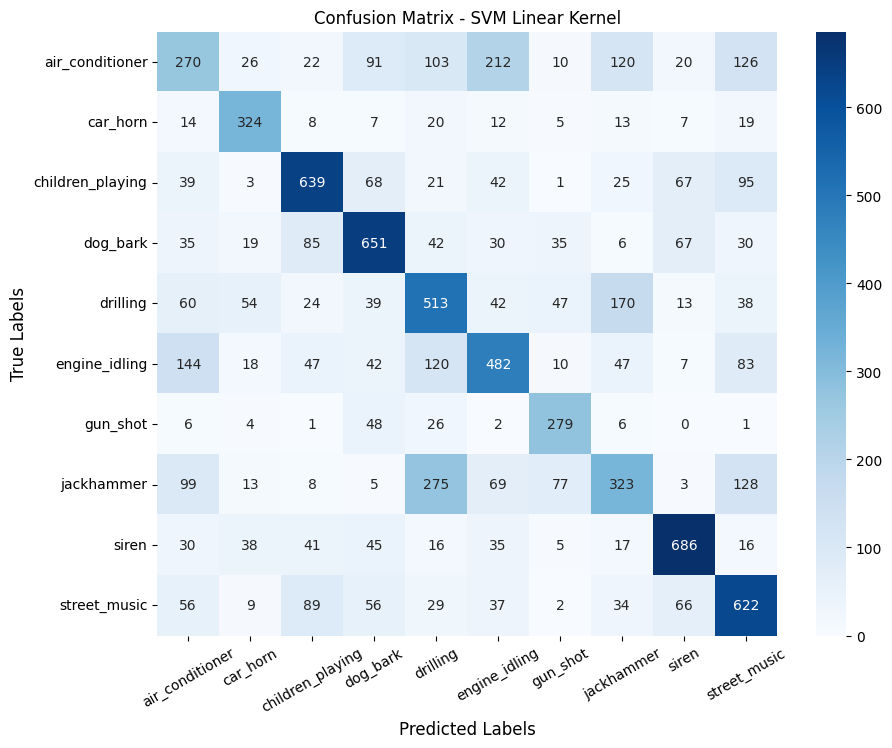

Epoch: 1000 with last epoch 1, Learning rate: 1e-05, C: 100000, Test Accuracy: 0.549, Time: 25.560 seconds


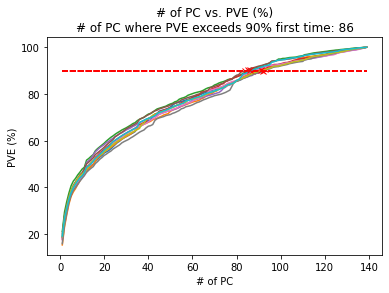

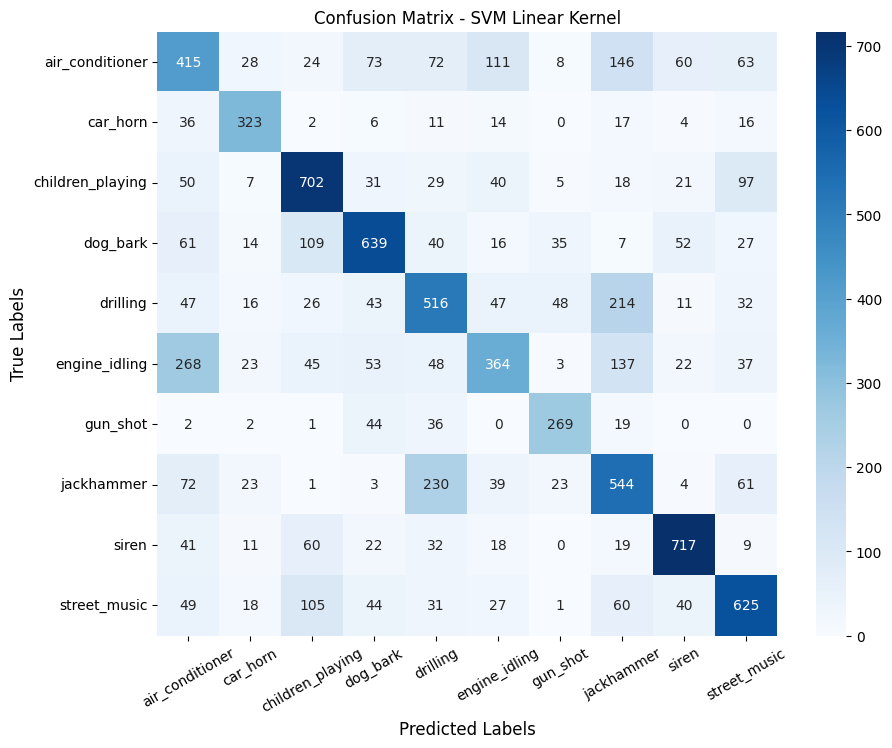

Epoch: 1000 with last epoch 3, Learning rate: 0.0001, C: 100, Test Accuracy: 0.586, Time: 34.547 seconds


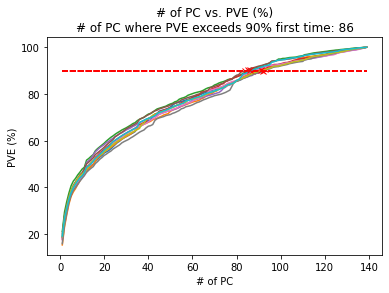

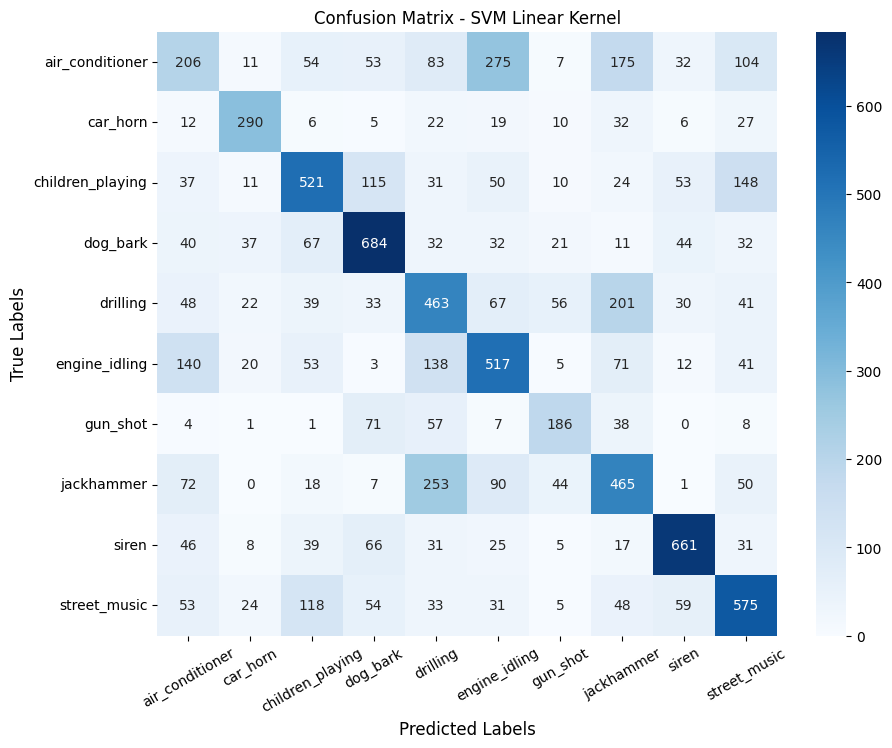

Epoch: 1000 with last epoch 1, Learning rate: 0.0001, C: 1000, Test Accuracy: 0.523, Time: 30.168 seconds


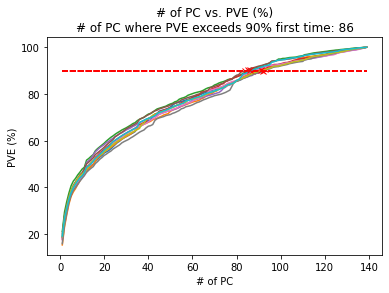

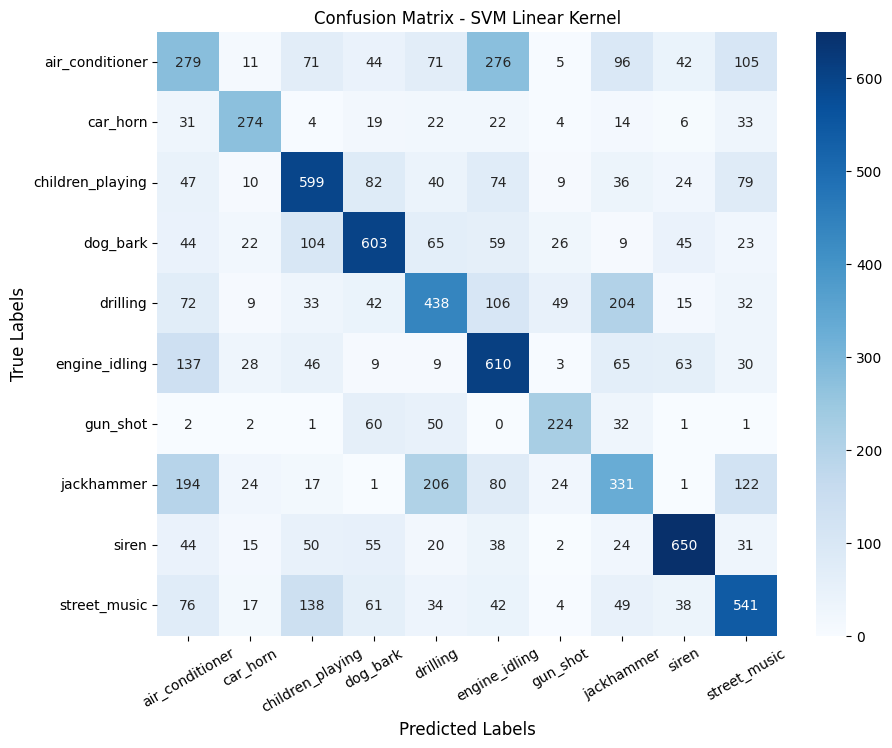

Epoch: 1000 with last epoch 1, Learning rate: 0.0001, C: 1000, Test Accuracy: 0.521, Time: 27.890 seconds


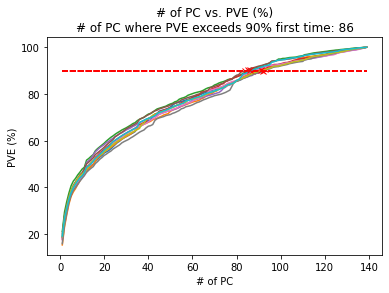

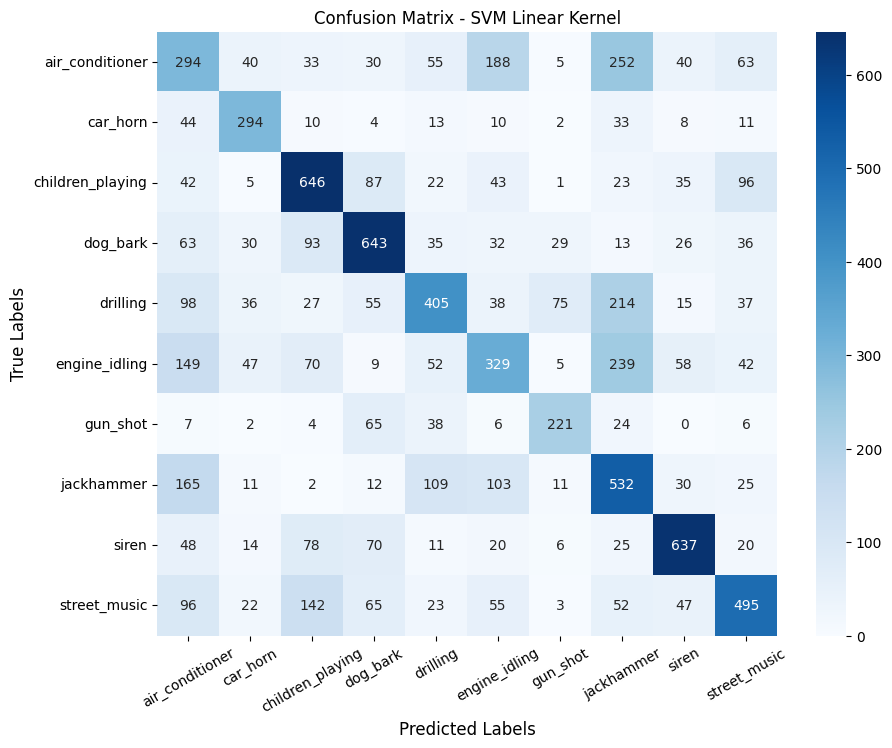

Epoch: 1000 with last epoch 2, Learning rate: 0.0001, C: 10000, Test Accuracy: 0.515, Time: 31.047 seconds


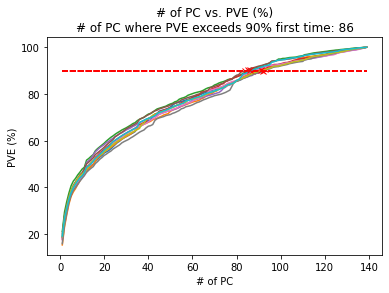

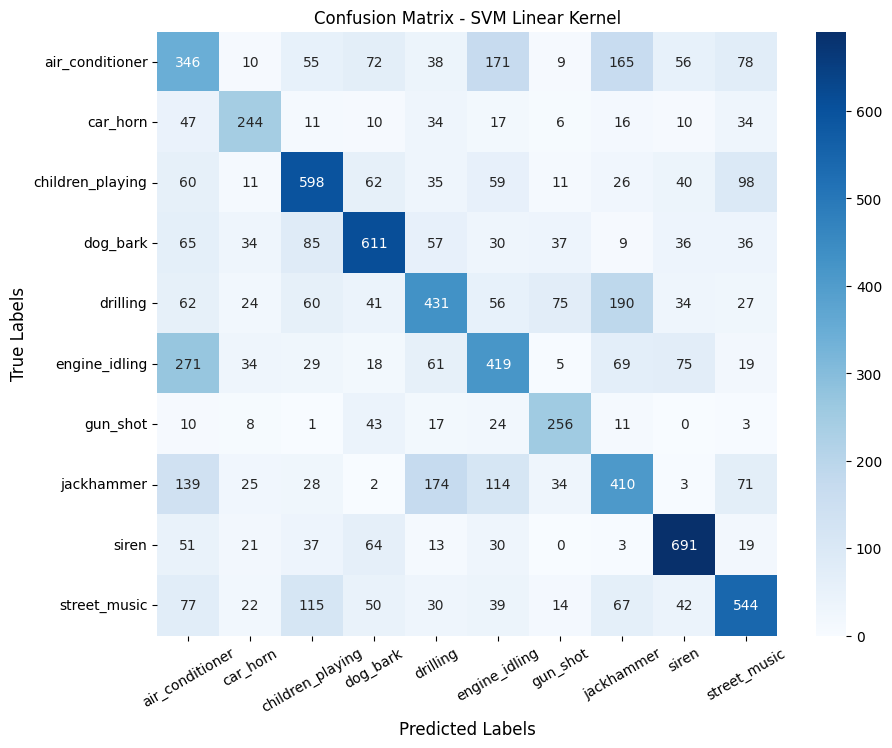

Epoch: 1000 with last epoch 2, Learning rate: 0.0001, C: 100000, Test Accuracy: 0.521, Time: 31.169 seconds


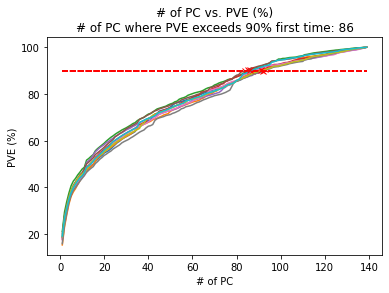

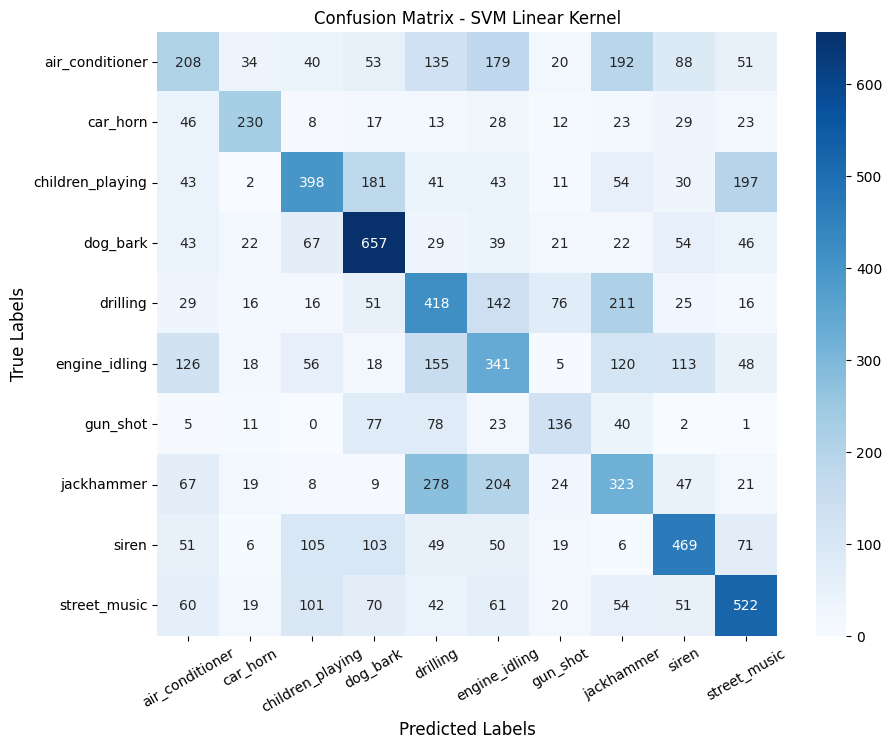

Epoch: 1000 with last epoch 2, Learning rate: 0.001, C: 100, Test Accuracy: 0.424, Time: 27.593 seconds


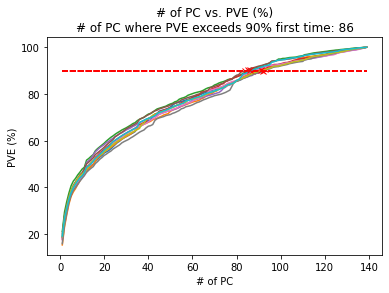

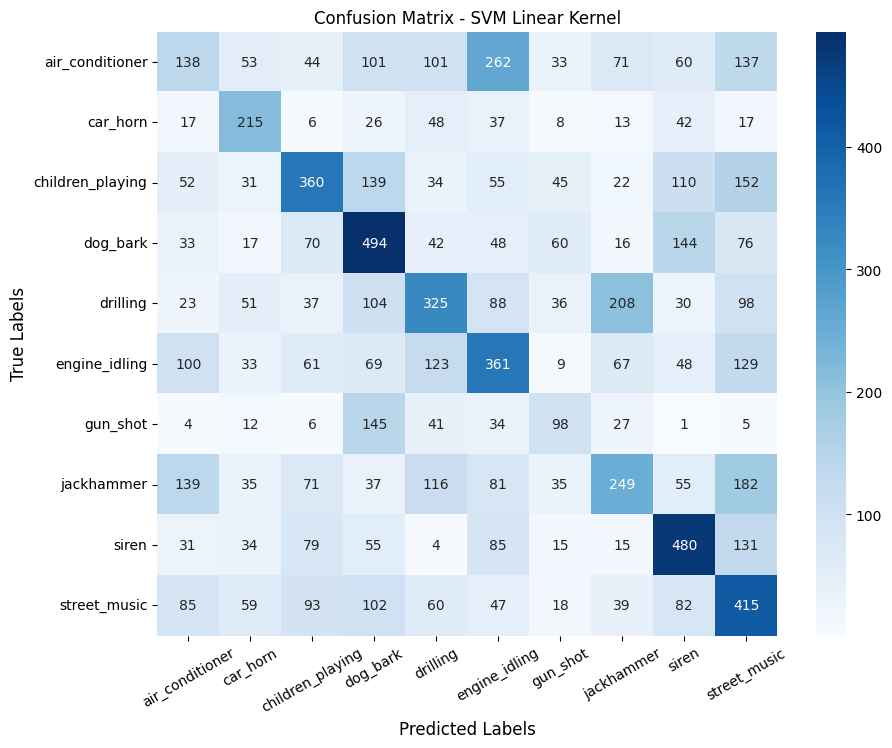

Epoch: 1000 with last epoch 1, Learning rate: 0.001, C: 1000, Test Accuracy: 0.359, Time: 26.214 seconds


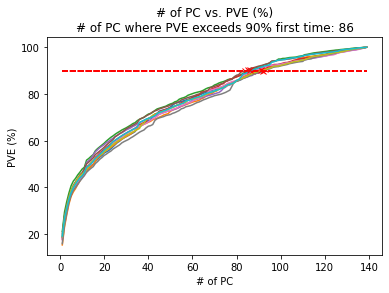

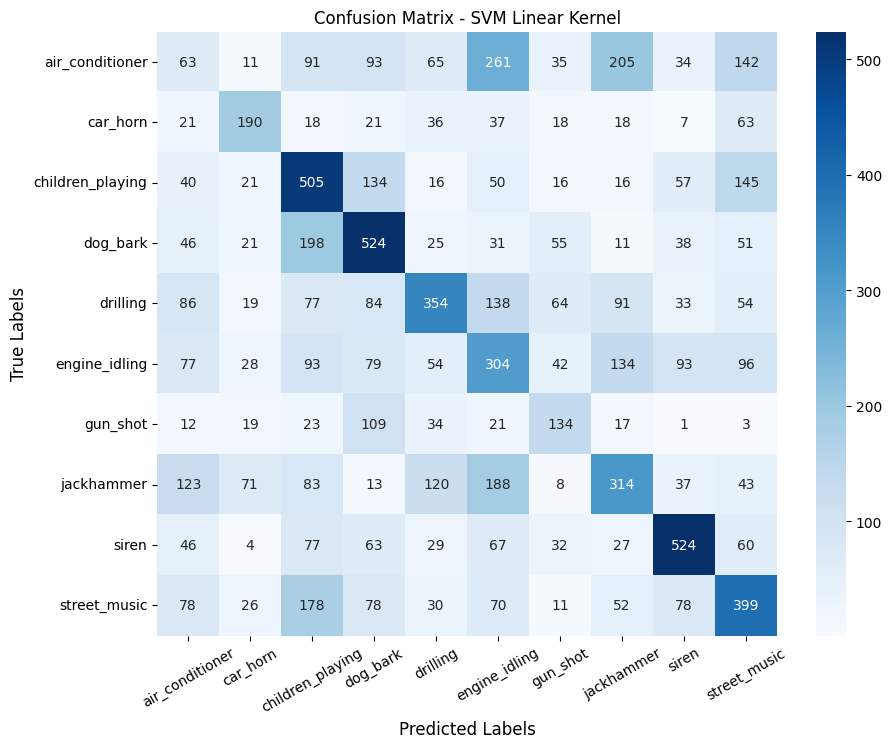

Epoch: 1000 with last epoch 4, Learning rate: 0.001, C: 1000, Test Accuracy: 0.379, Time: 29.636 seconds


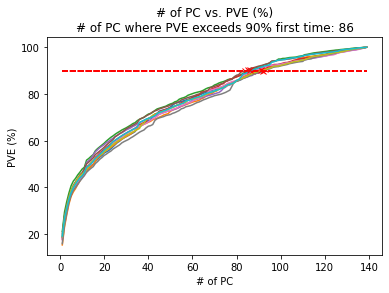

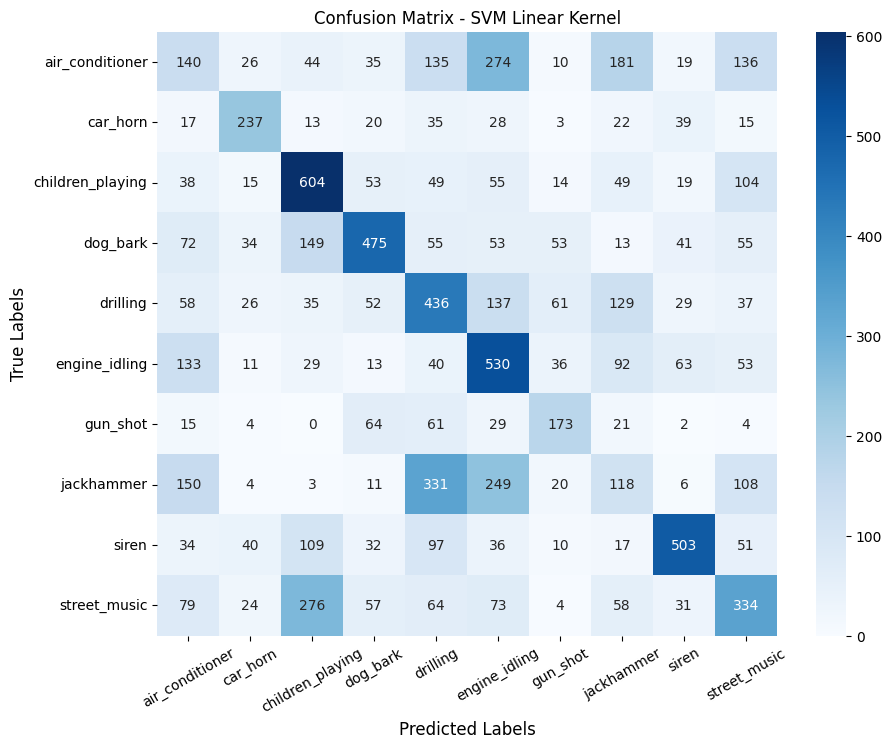

Epoch: 1000 with last epoch 2, Learning rate: 0.001, C: 10000, Test Accuracy: 0.407, Time: 28.676 seconds


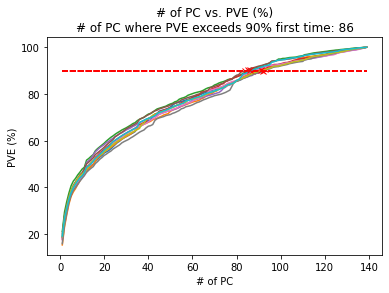

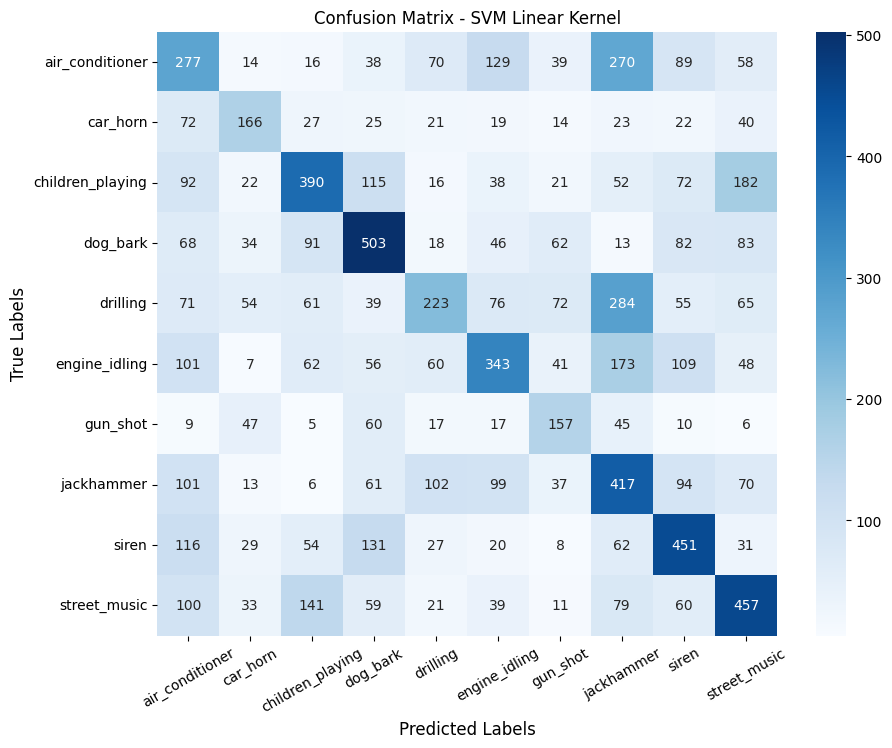

Epoch: 1000 with last epoch 2, Learning rate: 0.001, C: 100000, Test Accuracy: 0.388, Time: 25.212 seconds
array([[0.62925209, 0.63681136, 0.62547245, 0.59626618, 0.55869889],
       [0.62822128, 0.59409002, 0.5876761 , 0.55411751, 0.53751002],
       [0.62432711, 0.59672432, 0.59260108, 0.55068148, 0.54850533],
       [0.58572901, 0.52319322, 0.52101707, 0.51494674, 0.5211316 ],
       [0.42400641, 0.3590654 , 0.37922346, 0.40659718, 0.38758447]])


In [ ]:
from timeit import default_timer as timer
from pprint import pprint

epoch = 1000
lrs = [0.000001, 0.00001, 0.00001, 0.0001, 0.001] 
C_vals = [100, 1000, 1000, 10000, 100000]

accuracies = np.zeros((len(lrs), len(C_vals)))
output_lines = []
for i, lr in enumerate(lrs):
  for j, C in enumerate(C_vals):   
    corrects = 0
    lengths = 0
    time = 0
    y_preds = []
    y_true = []
    for fold_idx in range(0, 10):
      X_train, X_test, y_train, y_test = prepare_dataset(fold_idx)
      start = timer()
      W, _, last_epoch = stochastic_gd(X_train, y_train, epochs=epoch, lr=lr, C=C)
      end = timer()
      time += end - start
      preds = predict(W, X_test).flatten().astype(int)
      trues = np.argmax(y_test, axis=1)
      y_preds.append(preds)
      y_true.append(trues)

    y_preds = np.concatenate(y_preds, axis=None)
    y_true = np.concatenate(y_true, axis=None)

    acc, precision, recall, f1 = eval_metrics(y_preds, y_true)
    
    accuracies[i, j] = acc

    print(f'Epoch: {epoch} with last epoch {last_epoch}, Learning rate: {lr}, C: {C}, Test Accuracy: {acc:.3f}, Time: {time:.3f} seconds')

pprint(accuracies)

In [ ]:
import matplotlib.pyplot as plt

def loss_plot(lossess):
  pprint(lossess)
  plt.figure(figsize=(10, 8), dpi=100)
  total_epoch = 0
  min_len = 1e10
  for i in range(len(lossess)):
    min_len = min(len(lossess[i]), min_len)
    total_epoch += len(lossess[i])
  total_epoch /= len(lossess)
  lossess = np.array([np.array(i) for i in lossess])
  lossess = [np.mean(lossess[:,i]) for i in range(min_len)]
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(f'SVM Loss at Each Epoch Averaged on 10-Fold CV - Avg. Last Epoch = {total_epoch}')
  plt.plot(lossess[0])

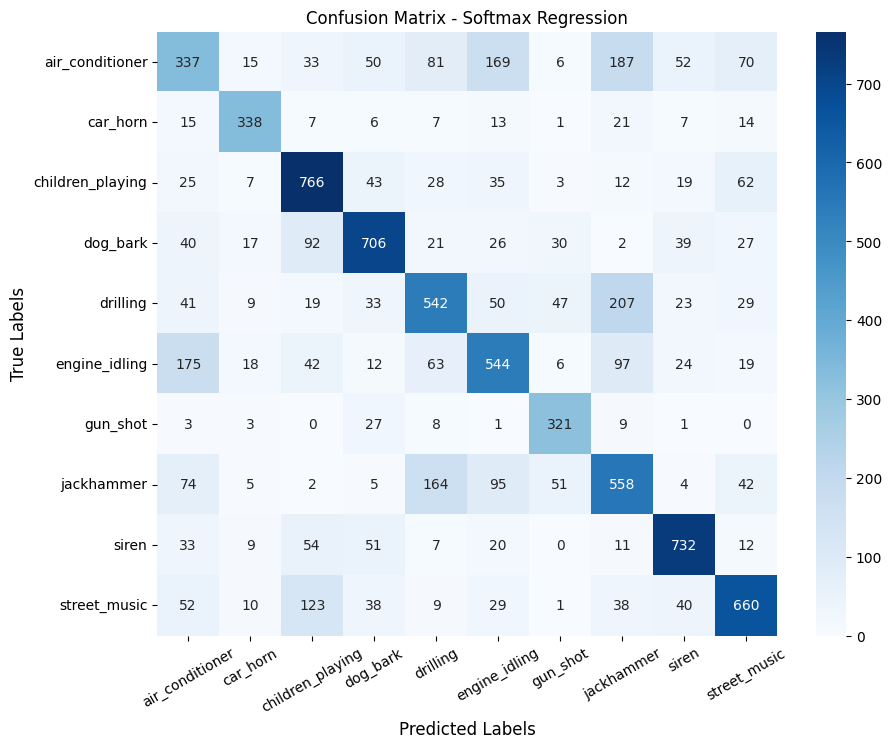

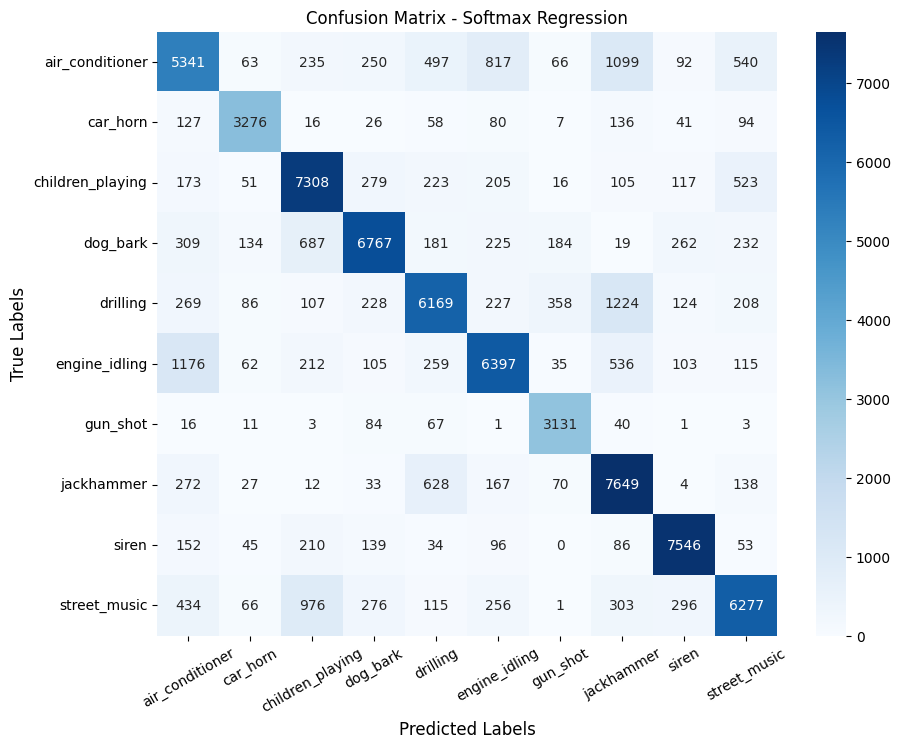

Epoch: 1000 with last epoch 11, Learning rate: 1e-06, C: 1000, Train Accuracy: 0.7617938635004263, Test Accuracy: 0.630, Time: 124.479 seconds, Exec. Time: 0.073 seconds
array([[0.63039743]])


In [ ]:
from timeit import default_timer as timer
from pprint import pprint
import csv

epoch = 1000
lrs = [0.000001] 
C_vals = [1000]

accuracies = np.zeros((len(lrs), len(C_vals)))
output_lines = []
for i, lr in enumerate(lrs):
  for j, C in enumerate(C_vals):   
    corrects = 0
    lengths = 0
    time = 0
    exec_time = 0
    y_train_preds = []
    y_train_true = []
    y_preds = []
    y_true = []
    lossess = []
    for fold_idx in range(0, 10):
      X_train, X_test, y_train, y_test = prepare_dataset(fold_idx)
      start = timer()
      W, losses, last_epoch = stochastic_gd(X_train, y_train, epochs=epoch, lr=lr, C=C)
      end = timer()
      time += end - start
      start = timer()
      preds = predict(W, X_test).flatten().astype(int)
      end = timer()
      exec_time += end - start
      trues = np.argmax(y_test, axis=1)
      y_preds.append(preds)
      y_true.append(trues)
      y_train_preds.append(predict(W, X_train).flatten().astype(int))
      y_train_true.append(np.argmax(y_train, axis=1))
      lossess.append(losses)

    y_preds = np.concatenate(y_preds, axis=None)
    y_true = np.concatenate(y_true, axis=None)
    y_train_preds = np.concatenate(y_train_preds, axis=None)
    y_train_true = np.concatenate(y_train_true, axis=None)

    with open(f'{CUR_PATH}/eval_metrics_svm.csv', 'w') as f:
      writer = csv.writer(f)

      # write the header
      writer.writerow(["Classes", "Precision", "Recall", "F1-Score"])

      # write multiple rows
      writer.writerows(zip(classes, precision, recall, f1))


    acc, precision, recall, f1 = eval_metrics(y_preds, y_true)

    train_acc, _, _, _ = eval_metrics(y_train_preds, y_train_true)

    accuracies[i, j] = acc

    print(f'Epoch: {epoch} with last epoch {last_epoch}, Learning rate: {lr}, C: {C}, Train Accuracy: {train_acc}, Test Accuracy: {acc:.3f}, Time: {time:.3f} seconds, Exec. Time: {exec_time:.3f} seconds')

pprint(accuracies)

In [ ]:
loss_plot(lossess)

[[1582.0104437010912,
  1442.831905709187,
  1410.802953103485,
  1363.6769047392786,
  1335.361818470732,
  1322.582768681182,
  1312.1214593240816,
  1300.9242886697045,
  1300.6346454941122,
  1292.3714916660772,
  1281.8855459833203,
  1278.1305837767493,
  1271.0350582402234,
  1268.076674871349,
  1262.2434691328756],
 [1576.4722254012522,
  1480.848218981467,
  1425.037386713839,
  1396.178587083689,
  1360.864705418631,
  1341.50452508159,
  1330.5177790662735,
  1319.6076914994428,
  1304.397236520206,
  1301.8340273710282,
  1299.773616623043],
 [1586.1081398528343,
  1497.7318251655963,
  1431.9224788092984,
  1397.778704258973,
  1370.6740097603445,
  1348.321521100491],
 [1569.402400277871,
  1465.663908198598,
  1408.6870997143967,
  1374.6017255008746,
  1351.6969149141732],
 [1588.5680798229293,
  1485.148917750405,
  1423.9278905796457,
  1391.9302441425773,
  1379.9105876401366,
  1346.1794669063415],
 [1578.629545301201,
  1457.2313975511547,
  1398.3732468908488,
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


IndexError: ignored

<Figure size 1000x800 with 0 Axes>

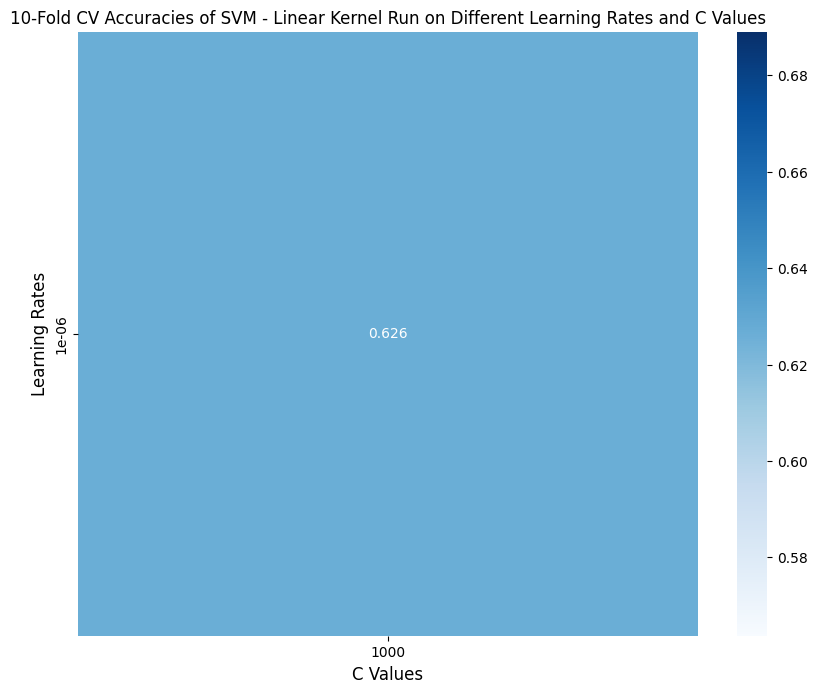

In [ ]:
conf_matrix = pd.DataFrame(data=accuracies, index=[str(lr) for lr in lrs], columns=[str(C) for C in C_vals])
plt.figure(figsize=(10, 8), dpi=100)
plt.title("10-Fold CV Accuracies of SVM - Linear Kernel Run on Different Learning Rates and C Values")

heatmap = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=".3f")
heatmap.set_xlabel("C Values", fontsize=12)
heatmap.set_ylabel('Learning Rates', fontsize=12)

plt.show()

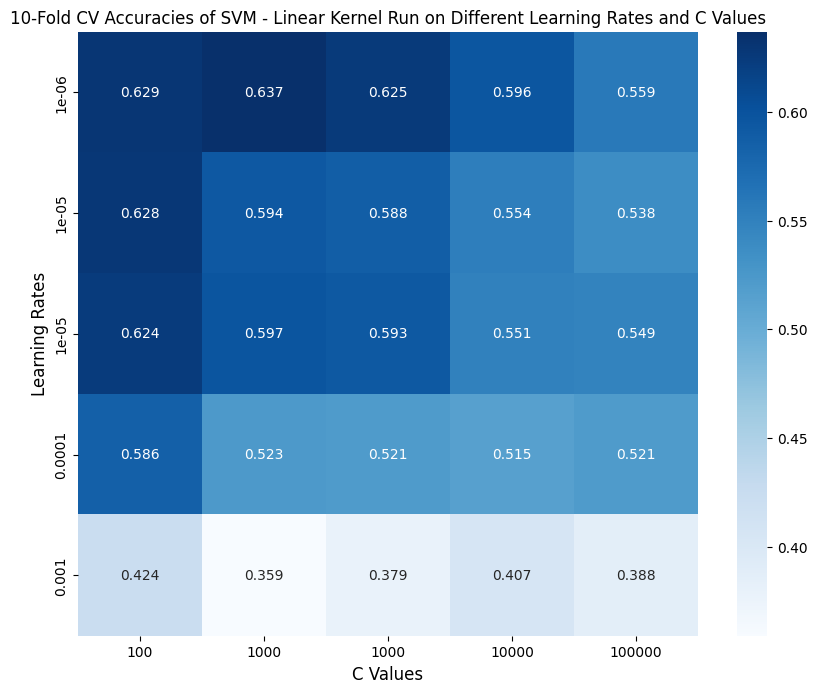

In [ ]:
import numpy as np
lrs = [0.000001, 0.00001, 0.00001, 0.0001, 0.001] 
C_vals = [100, 1000, 1000, 10000, 100000]
svm_hyperparamater = np.array([[0.62925209, 0.63681136, 0.62547245, 0.59626618, 0.55869889],
       [0.62822128, 0.59409002, 0.5876761 , 0.55411751, 0.53751002],
       [0.62432711, 0.59672432, 0.59260108, 0.55068148, 0.54850533],
       [0.58572901, 0.52319322, 0.52101707, 0.51494674, 0.5211316 ],
       [0.42400641, 0.3590654 , 0.37922346, 0.40659718, 0.38758447]])

conf_matrix = pd.DataFrame(data=svm_hyperparamater, index=[str(lr) for lr in lrs], columns=[str(C) for C in C_vals])
plt.figure(figsize=(10, 8), dpi=100)
plt.title("10-Fold CV Accuracies of SVM - Linear Kernel Run on Different Learning Rates and C Values")

heatmap = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=".3f")
heatmap.set_xlabel("C Values", fontsize=12)
heatmap.set_ylabel('Learning Rates', fontsize=12)

plt.show()


In [ ]:
from platform import python_version

print(python_version())

3.7.13
